# Author : Hitesh Vazir


# GRIPMAR21 - The Spark Foundation- Data Science & Business Analytics Internship

# Task 02 : Prediction using Unsupervised ML

# Task : From the given 'IRIS' dataset predict the optimal number of clusters and represents it visually

#  Setup the environment 

Importing the OS module for changing working Directory.

PANDAS,NUMPY for data manuplation.
Matplotlib,seaborn module for Data Visualisation. 

sklearn for modelling


In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
import sklearn.metrics as metrics

from mpl_toolkits.mplot3d import Axes3D


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# 2 .Importing  data

In [82]:
iris  =pd.read_csv("Iris.csv")


In [83]:
print(iris .head())
print('Data shape -->', iris .shape)

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
Data shape --> (150, 6)


In [84]:
iris["Species"].value_counts()


Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

# 3.Data preprocessing

In [85]:
data = iris.drop(['Species'], axis=1)
y = iris['Species']

### (i).Missing values

In [86]:
data.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
dtype: int64

### (ii) Data Visualisation

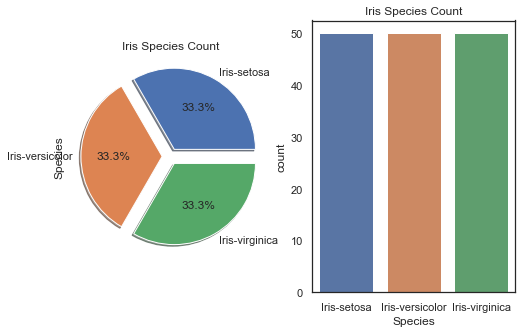

In [87]:
f,ax=plt.subplots(1,2,figsize=(8,5))
iris['Species'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Iris Species Count')
sns.countplot('Species',data=iris,ax=ax[1])
ax[1].set_title('Iris Species Count')
plt.show()

We can see that there are 50 samples each of all the Iris Species in the data set.



### FacetGrid Plot

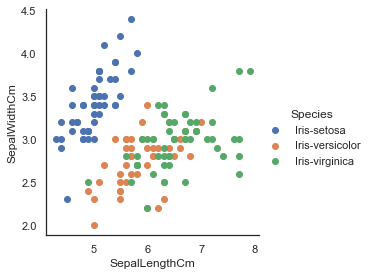

In [88]:
# Plotting species for Sepal
sns.FacetGrid(iris, hue="Species", size=4) \
   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
   .add_legend();

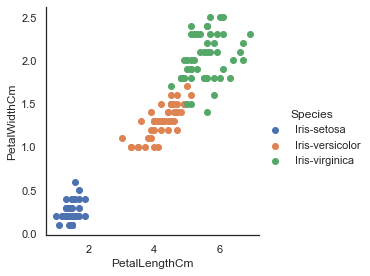

In [89]:
# Plotting species for petals
sns.FacetGrid(iris, hue="Species", size=4) \
   .map(plt.scatter, "PetalLengthCm", "PetalWidthCm") \
   .add_legend();

Observed that the species are nearly linearly separable with petal size, but sepal sizes are more mixed.This is an indication that the Petals can help in better and accurate Predictions over the Sepal

### Boxplot

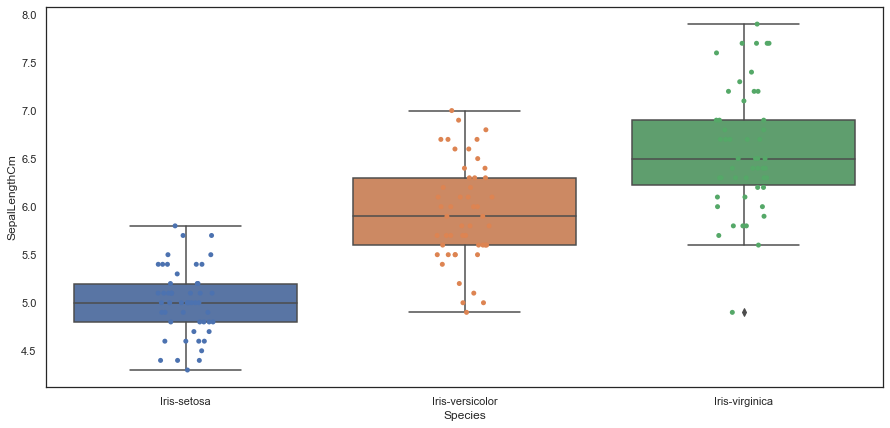

In [90]:
fig=plt.gcf()
fig.set_size_inches(15,7)
fig=sns.boxplot(x='Species',y='SepalLengthCm',data=iris)
fig=sns.stripplot(x='Species',y='SepalLengthCm',data=iris,jitter=True,edgecolor='yellow')

We can observe from the box plot of Iris-Virginica , there are some outliers 

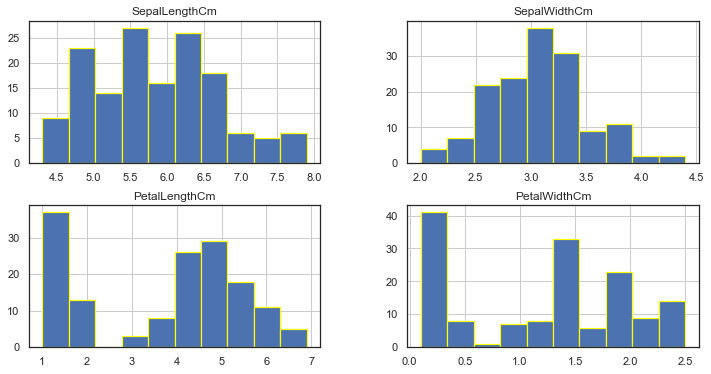

In [91]:
tmp = iris.drop('Id', axis=1)
tmp.hist(edgecolor='yellow', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

<AxesSubplot:xlabel='Species', ylabel='SepalWidthCm'>

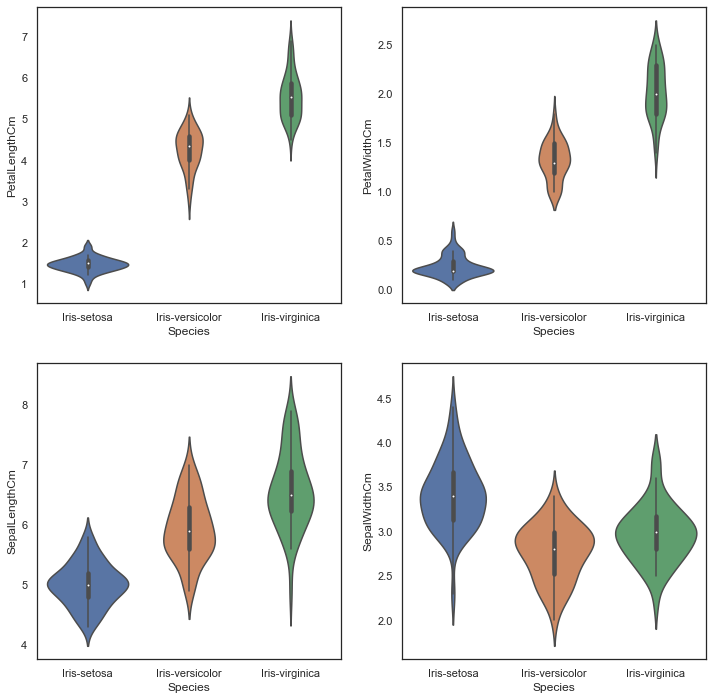

In [92]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.violinplot(x='Species',y='PetalLengthCm',data=iris)
plt.subplot(2,2,2)
sns.violinplot(x='Species',y='PetalWidthCm',data=iris)
plt.subplot(2,2,3)
sns.violinplot(x='Species',y='SepalLengthCm',data=iris)
plt.subplot(2,2,4)
sns.violinplot(x='Species',y='SepalWidthCm',data=iris)

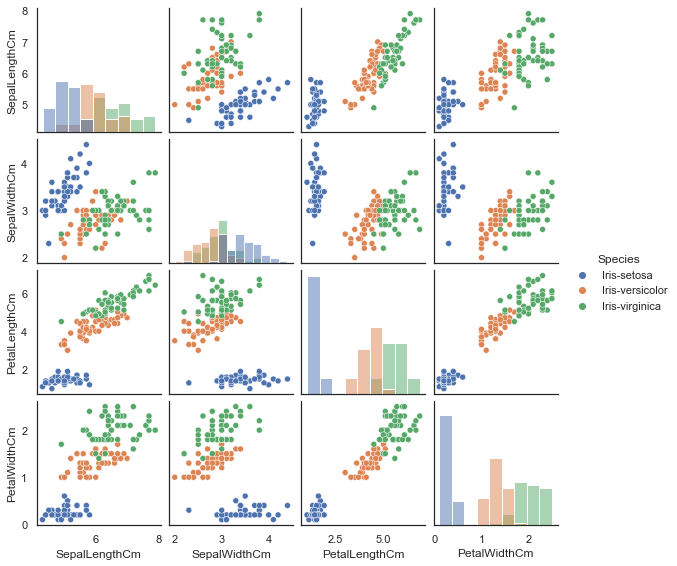

In [93]:
sns.pairplot(tmp, hue="Species", diag_kind="hist", size=2.0);


This shows how similar versicolor and virginica are, at least with the given features.But there could be features that you didn't measure that would more clearly separate the species.It's the same for any unsupervised learning - you need to have the right features to separate the groups in the best way.

### Converting Species to numeric

In [94]:
def y_label (invalue):
    if invalue == 'Iris-setosa' :
        return 1
    elif invalue == 'Iris-virginica' :
        return 0
    else :
        return 2
df1 = pd.DataFrame(data=y.values, columns=['species'])

df1['index']=df1['species'].apply(y_label) 

    
    

# 4  Data Preparation

The data we are using to build a clustering should

        1. Always be numeric and 
      2.should always be on same scale


### (i) Data Type

In [95]:
data.dtypes

Id                 int64
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
dtype: object

   
The features we are using for clustering are numeric

### (ii).Scaling the data

In [96]:
std_scale = StandardScaler().fit(data)
data_scaled = std_scale.transform(data)

X_scaled = pd.DataFrame(data_scaled, columns = data.columns)

X_scaled.sample(5)



,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
110,0.819856,0.795669,0.337848,0.762759,1.053537
84,0.219398,-0.537178,-0.124958,0.421564,0.396172
129,1.258652,1.643844,-0.124958,1.160819,0.527645
65,-0.219398,1.038005,0.106445,0.364699,0.264699
98,0.542721,-0.900681,-1.281972,-0.431421,-0.129720


  Hence before we feed a data to a clustering algorithm it becomes imperative to bring our data on the same scale by using StandardScaler

# 4 (a) K-Means algorithm

Lets try to visulaize the data if we can segreggate into clusters

### (i).Scatter plot to visualise the scaled data and intial centriods for given K -clusters (K-Means)

In [97]:
def plot_kmeans_scale(k) :
  
    kmeans_model = KMeans(n_clusters=k, random_state=123)
    kmeans_model.fit(data_scaled)
    #Make predictions
    labels=kmeans_model.predict(data_scaled)
    #to get centroids
    centroid=kmeans_model.cluster_centers_
    colors=['r','g','p','b','o','y','m','w']
    fig = plt.figure(1, figsize=(3,3))
    kx = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=120)
    for i in range(k) :
        points=np.array([data_scaled[j]for j in range(len(data_scaled))if labels[j]>=i])
        kx.scatter(points[:, 3], points[:, 0], points[:, 2],s=5, cmap='jet')#colors[i]) 
        kx.scatter(centroid[:,0],centroid[:,1],marker='*',s=200,c='red')
      
        #plt.title('Number of clusters = {}'.format(k))
        plt.show()


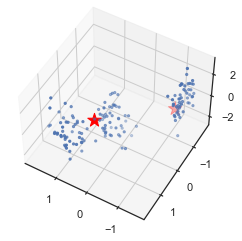

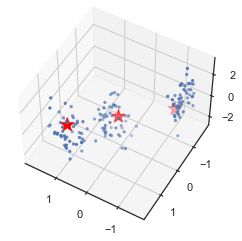

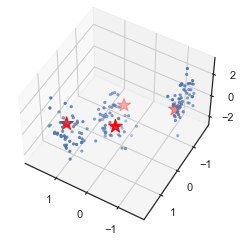

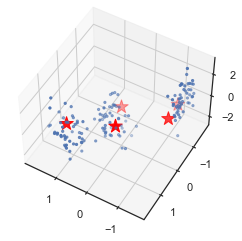

In [98]:
k=5
for i in range(k+1):
    if  i>1 :
        plot_kmeans_scale(i)

     Initial centroids are indicated as red stars.
     Starting with k =2 to 5 we ran the code, 
                Squared Euclidean distance measures the distance between each data point and the centroid, then the centroid will be re-calculated until the stop criteria and the following are screen shots of the results.
                A good choice of number of clusters will lead to compact and well separated clusters.
                That is to maximize intra-cluster similarity, and minimize inter-cluster similarity.
                

    Measure the compactness of clusters( inter-cluster similarity), We can compute a measure called "Within Sum of Squares for this cluster(WSS)"for each cluster or we can take an average. 

### (ii) Finding optimal number of clusters - Plot Scree pot/Elbow Plot

The technique we use to determine optimum K, the number of clusters, is called the elbow method.

Text(3.1, 5001, 'optimal number of clusters = 3')

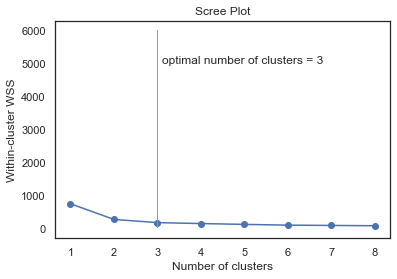

In [99]:
k=9
WSS = []
for k in range(1,9):
        kmeans_model = KMeans(n_clusters=k, random_state=123)
        kmeans_model.fit(data_scaled)
        WSS.append(kmeans_model.inertia_)
plt.plot(range(1,9), WSS, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster WSS")
plt.title("Scree Plot")
plt.plot([3]*6000, range(1,6001), ",")
plt.text(3.1, 5001, "optimal number of clusters = 3")
            
            

            

By plotting the number of centroids and the average distance between a data point and the centroid within the cluster we arrive at the above graph.

     inertia_ :The sum of squared distances within (WSS) the cluster to its centroid.
     
       Higher inertia_ refers to higher spread of data points from its own centroid. Lower inertia_ refers to higher concentration of datapoints at its own centroid. 
    From the Scree plot, inertia_ is decreasing with higher number of clusters. However, decrease in inertia_ got flattened from 4 clusters onwards. 
    To finalise the optimum number of clusters need to the similarity of data points in its own cluster compared to other clusters. This can be measured using Silhouette Score.

    The Silhouette score is maximum for 3 clusters. Also, it is evident from Scree curve ,inertia_ got flattened for 4 clusters onwards.
    
    Hence, based on Silhouette score and scree plot 3 clusters were considered as optimal clusters
    

In [100]:

for i in range(2,8):
    labels=KMeans(n_clusters=i,random_state=123).fit(data_scaled).labels_
    print ("Silhoutte score for k= "+str(i)+" is "+str(metrics.silhouette_score(data_scaled,labels,metric="euclidean",random_state=123)))


Silhoutte score for k= 2 is 0.570815210603504
Silhoutte score for k= 3 is 0.452949780355554
Silhoutte score for k= 4 is 0.40861284028852807
Silhoutte score for k= 5 is 0.3378584262857905
Silhoutte score for k= 6 is 0.3271727707773155
Silhoutte score for k= 7 is 0.3353547831959095


    The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters (separation). The value of this messure range from -1 to 1 and higher the value indicates maximum similarity in its own cluster.
    


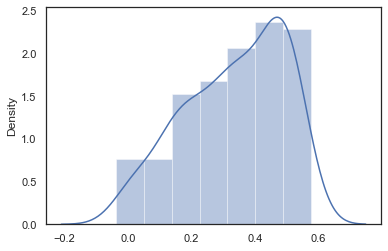

In [101]:
scores = metrics.silhouette_samples(data_scaled, labels)
sns.distplot(scores);

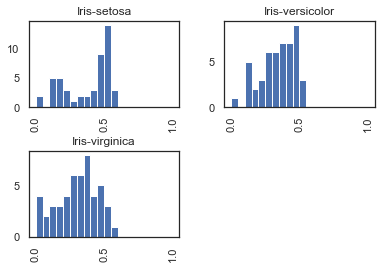

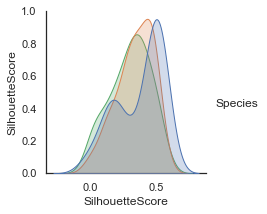

In [102]:
df_scores = pd.DataFrame()
df_scores['SilhouetteScore'] = scores
df_scores['Species'] = iris['Species']
df_scores.hist(by='Species', column='SilhouetteScore', range=(0,1.0), bins=20);
sns.pairplot(df_scores, hue="Species", size=3);


### (iii). K-means clustering with 3 optimal Clusters

In [103]:
km = KMeans(n_clusters=3, random_state=123)
km.fit(data_scaled)
print('inertia with clusters=3 -->' ,km.inertia_)
km.cluster_centers_

inertia with clusters=3 --> 177.05608895062977


array([[ 1.14317894,  1.03542672, -0.07079946,  1.04224753,  1.09269889],
       [-1.1547262 , -1.01457897,  0.84230679, -1.30487835, -1.25512862],
       [ 0.07560189,  0.03894137, -0.73184462,  0.30676007,  0.21508647]])

### (iv) Make predictions on the lables using K=3

In [104]:
predicted_cluster = km.predict(data_scaled)
predicted_labels = km.labels_


### (v).  Plot the scaled data partitioned into optimal clusters K=3

Text(0.5, 0.92, 'K Means')

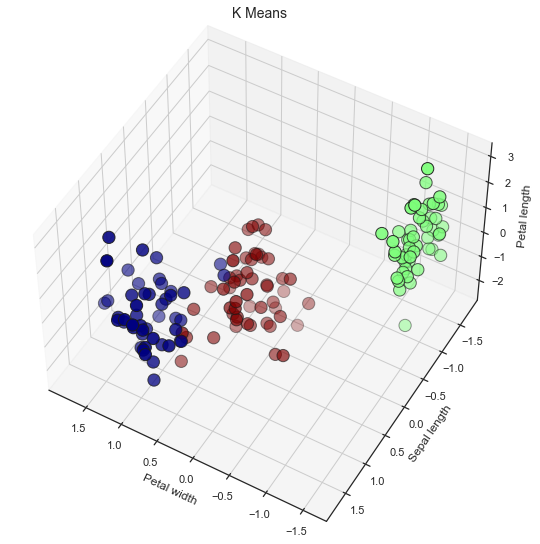

In [105]:
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=120)
ax.scatter(data_scaled[:, 3], data_scaled[:, 0], data_scaled[:, 2],
          c=predicted_labels.astype(np.float), cmap='jet',edgecolor="k", s=150)
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
plt.title("K Means", fontsize=14)

### (vi) Comparing Clustered data with original data for defining boundaries of 3 clusters(k-means)

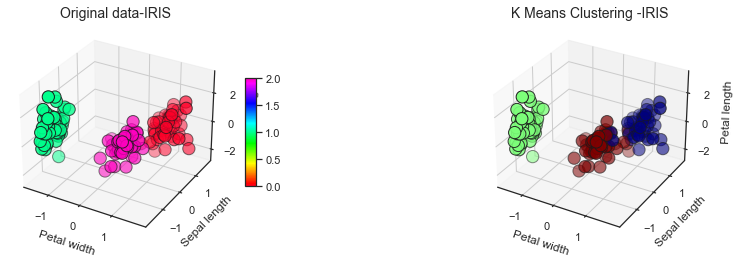

In [106]:
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf =ax.scatter(data_scaled[:, 3], data_scaled[:, 0],data_scaled[:, 2],
          c=df1['index'],  cmap='gist_rainbow',edgecolor="k", s=150)
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")

plt.title("Original data-IRIS", fontsize=14)

fig.colorbar(surf, shrink=0.5, aspect=10)

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.scatter(data_scaled[:, 3], data_scaled[:, 0], data_scaled[:, 2],
           c=predicted_labels.astype(np.float), cmap='jet',edgecolor='k', s=150)
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
plt.title("K Means Clustering -IRIS", fontsize=14)
plt.show()

### Observations

   In conclusion, from Silhouette score and Scree plot, we can be clustered to 3 main groups of species :

          
 we can infer that the sepal sizes are more mixed, so the clustering algorithm cant vary much difference between two species i.e  versicolor and virginica species. And also note that the species are nearly linearly separable with petal size,
    we can compare this range of values with the original data (which is not scaled) 



### (vi) Create cluster profiles compare with Original Data labels

In [107]:
def predict_species (invalue):
    if invalue == 1:
        return 'Iris-setosa' 
    elif invalue == 0 :
        return 'Iris-virginica'
    else :
        return 'Iris-versicolor'
df1['predict_label']= pd.DataFrame(data=predicted_labels, columns=['predict_label'])

df1['predict_species']=df1['predict_label'].apply(predict_species) 


In [108]:
sum(np.where((df1['species']!=df1['predict_species']),1,0))

7

In [109]:
df1[df1['species']!=df1['predict_species']]

,species,index,predict_label,predict_species
77,Iris-versicolor,2,0,Iris-virginica
86,Iris-versicolor,2,0,Iris-virginica
101,Iris-virginica,0,2,Iris-versicolor
106,Iris-virginica,0,2,Iris-versicolor
113,Iris-virginica,0,2,Iris-versicolor
119,Iris-virginica,0,2,Iris-versicolor
121,Iris-virginica,0,2,Iris-versicolor


By K-means clustering with number of clusters=3 , we are able to cluster 143 species correctly out of 150 species.The cluster Iris-versicolor and Iris-virginica are misclustered.

# Thank You Task -2 Ends Here